In [17]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
from copy import deepcopy
import bayesian_torch
import torchcontrib

import sys
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/paper")
from src.optimizers.entropy_sgd import EntropySGD
from laplace import Laplace
from torch.utils.data import TensorDataset
from tqdm import tqdm
from blitz.modules import BayesianLinear, BayesianConv2d
from blitz.utils import variational_estimator
from torch.nn.utils import vector_to_parameters

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (5, 3)
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Computer Modern'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

# Marquis de Laplace's color 
c1 = (38/255, 81/255, 206/255)
c2 = (232/255, 220/255, 87/255)
c3 = (238/255, 238/255, 238/255)
c4 = (0, 0, 0)
# some plotting options
A4_width = 8.27
A4_height = 11.69
# just one column 
textwidth = 5.50107

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Predictive

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


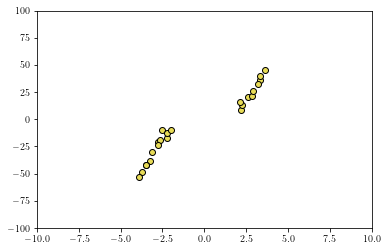

In [18]:
np.random.seed(9999)

# Toy problem from PBP paper (Lobato-Hernandez & Adams, 2015)
train_size = 50
data_noise = 3

X = np.random.uniform(-4, 4, size=(train_size, 1))
X = np.array([x for x in X if x < -2 or x > 2])
y = X**3 + np.random.randn(*X.shape)*data_noise  # Noise is N(0, 3^2)

plt.scatter(X.flatten(), y.flatten(), c=c2, edgecolor=c4);
plt.xlim(-10, 10);
plt.ylim(-100, 100);

In [19]:
from torch.nn.utils import parameters_to_vector
from backpack import extend, backpack
from backpack.extensions import DiagGGNExact


torch.manual_seed(7777)

m, n = X.shape
h = 20  # num. hidden units per layer
k = 1  # num. of output unit
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float()


In [20]:
def train_model(tau, init_model):
    model = deepcopy(init_model)
    loss_fun = nn.MSELoss()
    extend(model)
    extend(loss_fun)
    weight_decay = 5e-4
    opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=weight_decay)

    sgd_trajectories = [parameters_to_vector(model.parameters()).detach().numpy()]

    for it in range(2001):
        with backpack(DiagGGNExact()):
            y_pred = model(X_train)
            l = loss_fun(y_pred, y_train)
            l.backward(create_graph=True)
        log_det_loss = 0
        if tau > 0:
            for name, param in model.named_parameters():
                    log_det_loss += param.diag_ggn_exact.log().mean()
            (tau * log_det_loss/X_train.shape[0]).backward()
        opt.step()
        opt.zero_grad()
        
        if it % 1 == 0:
            sgd_trajectories.append(parameters_to_vector(model.parameters()).detach().numpy())
            
    sgd_trajectories = np.array(sgd_trajectories)
    print(f'Loss: {l.item():.3f}')
    return sgd_trajectories, model

In [21]:
init_model = nn.Sequential(nn.Linear(n,h), nn.Tanh(), nn.Linear(h, 1))
sgd_01, model_01 = train_model(4, init_model)
sgd_trajectories, model = train_model(0, init_model)

Loss: 5.630
Loss: 5.626


In [22]:
def train_swa(tau, init_model):
    model = deepcopy(init_model)
    loss_fun = nn.MSELoss()
    extend(model)
    extend(loss_fun)
    weight_decay = 5e-4
    opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=weight_decay)
    swa_opt = torchcontrib.optim.SWA(opt, swa_start=1500, swa_freq=10, swa_lr=1e-2)
    swa_opt.param_groups = swa_opt.optimizer.param_groups
    swa_opt.state = swa_opt.optimizer.state
    swa_opt.defaults=swa_opt.optimizer.defaults

    sgd_trajectories = [parameters_to_vector(model.parameters()).detach().numpy()]

    for it in range(2001):
        y_pred = model(X_train)
        l = loss_fun(y_pred, y_train)
        l.backward()
        swa_opt.step()
        swa_opt.zero_grad()
        
        if it % 1 == 0:
            sgd_trajectories.append(parameters_to_vector(model.parameters()).detach().numpy())
            
    sgd_trajectories = np.array(sgd_trajectories)
    swa_opt.swap_swa_sgd()
    sgd_trajectories[-1] = parameters_to_vector(model.parameters()).detach().numpy()

    print(f'Loss: {l.item():.3f}')
    return sgd_trajectories, model

In [23]:
swa_traj, swa_model = train_swa(0, init_model)

Loss: 10.823


In [24]:
def train_entropy(tau, init_model):
    model = deepcopy(init_model)
    loss_fun = nn.MSELoss()
    extend(model)
    extend(loss_fun)
    weight_decay = 5e-4
    config = {"lr": 1e-3, "momentum":0.9, "weight_decay":weight_decay, "L":5, "g0":1e-1, "g1":0, "noise":1e-4, "nesterov":False}
    opt = EntropySGD(model.parameters(),config=config)
    sgd_trajectories = [parameters_to_vector(model.parameters()).detach().numpy()]

    def closure():
        loss = loss_fun(model(X_train), y_train)
        loss.backward()
        return loss, None
    for it in range(2001):
        l,_ = opt.step(closure=closure, model=model, criterion=nn.MSELoss())
        
        if it % 1 == 0:
            sgd_trajectories.append(parameters_to_vector(model.parameters()).detach().numpy())
            
    sgd_trajectories = np.array(sgd_trajectories)

    print(f'Loss: {l.item():.3f}')
    return sgd_trajectories, model
ent_traj, ent_model = train_entropy(0, init_model=init_model)

Loss: 178.157


In [25]:
ent_traj

array([[ 0.4906242 ,  0.46557808, -0.53003967, ..., -0.18361571,
        -0.14194942, -0.09546643],
       [ 0.340647  ,  0.48149025, -0.05251978, ..., -0.06134549,
        -0.10769724, -0.10632835],
       [ 0.11915686,  0.5113759 ,  0.66163707, ...,  0.10246632,
        -0.06196085, -0.12621015],
       ...,
       [13.674656  ,  4.358286  , 10.790773  , ...,  1.2074934 ,
        -0.14814869, -1.1655728 ],
       [13.674258  ,  4.35817   , 10.790459  , ...,  1.2074368 ,
        -0.14816673, -1.1654783 ],
       [13.673861  ,  4.358053  , 10.790144  , ...,  1.2073779 ,
        -0.14818695, -1.1653918 ]], dtype=float32)

In [26]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from copy import deepcopy

In [27]:
1/sqrt(2* 5e-4 * X_train.shape[0])

6.593804733957869

In [28]:
@variational_estimator
class VariationalToyModel2D(nn.Sequential):
    def __init__(self, **kwargs):
        h = 20  # num. hidden units per layer
        n = 1
        # 0.005 , 0.1
        # 0.01, 0.01 better
        bayesian_args = {"prior_sigma_1":0.01, "prior_sigma_2":0.01}#0.001}
        feature_map = nn.Sequential(
            BayesianLinear(n, h, **bayesian_args),
            nn.Tanh()
        )
        clf = BayesianLinear(h, 1, bias=True, **bayesian_args)
        super(VariationalToyModel2D, self).__init__(feature_map, clf)

def get_blitz_params(model:nn.Module, key:str, exclude:str="sampler") -> torch.Tensor:
    params = []
    for name, param in model.named_parameters():
        if (key in name):
            if not exclude or (not exclude in name):
                params.append(param)
    return params        

def copy_params_from_bnn(bnn:nn.Module, nn:nn.Module, key="mu"):
    state_dict = parameters_to_vector(get_blitz_params(bnn, key=key))
    vector_to_parameters(state_dict, nn.parameters())


def copy_params_to_bnn(bnn:nn.Module, nn:nn.Module, key="mu"):
    state_dict = parameters_to_vector(nn.parameters()).detach().clone()
    bnn_parameters = get_blitz_params(bnn, key=key)
    bnn_samples_params = get_blitz_params(bnn, key="sampler.mu", exclude=None)
    vector_to_parameters(state_dict, bnn_parameters)
    vector_to_parameters(state_dict, bnn_samples_params)

    
bnn_model = VariationalToyModel2D()
copy_params_to_bnn(bnn_model, init_model)
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(bnn_model.parameters(), lr=1e-3, momentum=0.9)
bnn_trajectory = []
for i in range(2001):
        bnn_trajectory.append(parameters_to_vector(get_blitz_params(bnn_model, key="mu")).detach().clone())
        optimizer.zero_grad()
        output = bnn_model(X_train)
        kl = bnn_model.nn_kl_divergence()
        ce_loss = criterion(output, y_train)
        loss = ce_loss +  kl / X_train.shape[0] * 20
        loss.backward()
        optimizer.step()
bnn_trajectory = torch.vstack(bnn_trajectory)

In [29]:
def plot(X_test, mean, std=None, fname=None):
    plt.plot(X_test, mean, c=c4, lw=3);
    plt.plot(X_test, mean, c=c4, lw=2);
    
    if std is not None:
        plt.fill_between(X_test.flatten(), mean-1.96*std, mean+1.96*std, color=c1, alpha=0.3);

    plt.scatter(X.flatten(), y.flatten(), marker='X', s=50, c='white', edgecolors='black', lw=1, zorder=100);
    plt.xlim(-8, 8); plt.xticks([]);
    plt.ylim(-100, 100); plt.yticks([]);
    
    if fname is not None:
        plt.savefig(f'figs/{fname}.pdf', bbox_inches='tight')
        
    plt.show();

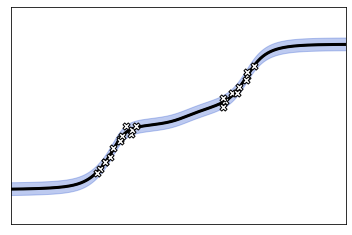

In [30]:
X_test_np = np.linspace(-10, 10, 1000).reshape(-1, 1)
X_test = torch.from_numpy(X_test_np).float()

y_pred = model(X_test).squeeze().detach().numpy()

plot(X_test_np, y_pred, std=3*np.ones_like(y_pred))

### Laplace

In [31]:
def fit_la(model, train_set):
    model_for_la = deepcopy(init_model)
    model_for_la.load_state_dict(model.state_dict())
    model_la = Laplace(model=model_for_la, likelihood="regression", subset_of_weights="all", hessian_structure="kron")
    model_la.fit(train_set)
    log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
    hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
    for i in tqdm(range(100)):
        hyper_optimizer.zero_grad()
        neg_marglik = - model_la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
        neg_marglik.backward()
        hyper_optimizer.step()
    return model_la

@torch.no_grad()
def plot_predictions(model, axs, prob=True):
    if prob:
        mean, var = model(X_test)
        # mean, var = model(X_test, pred_type="nn", n_samples=1000)
        std = torch.sqrt(torch.flatten(var) + model.sigma_noise.item()**2)
        mean = mean.flatten()
    else:
        mean = model(X_test).flatten()
        std = np.ones_like(mean)
    axs.plot(X_test, mean, c=c4, lw=3);
    axs.plot(X_test, mean, c=c4, lw=2);
    
    if std is not None:
        axs.fill_between(X_test.flatten(), mean-1.96*std, mean+1.96*std, color=c1, alpha=0.3);

    axs.scatter(X.flatten(), y.flatten(), marker='X', s=50, c='white', edgecolors='black', lw=1, zorder=100);
    axs.set_xlim(-8, 8)
    axs.set_xticks([])
    axs.set_ylim(-100, 100)
    axs.set_yticks([])
    # plt.show();


100%|██████████| 100/100 [00:00<00:00, 807.92it/s]


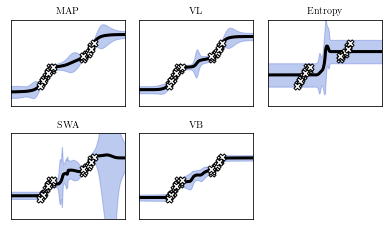

In [60]:
dataloader = TensorDataset(X_train.unsqueeze(dim=0), y_train.unsqueeze(dim=0))
dataloader.dataset = X_train

# some plotting options
A4_width = 8.27
A4_height = 11.69
# just one column 
textwidth = 5.50107
fig, axs = plt.subplots(2, 3, figsize=(textwidth, 0.6* textwidth))

for cur_model, name, cur_ax in zip([model, model_01, ent_model, swa_model], ["MAP", "VL", "Entropy", "SWA"],  axs.flat):
    model_la = fit_la(cur_model, dataloader)
    plot_predictions(model_la, cur_ax)
    cur_ax.set_title(name, fontsize=10)

# add vb
sample_preds = []
with torch.no_grad():
    for i in range(1000):
        sample_preds.append(bnn_model(X_test))
sample_preds = torch.stack(sample_preds).flatten(-2)
pred_mean = sample_preds.mean(dim=0)
pred_std = sample_preds.std(dim=0)

vb_axs = axs.flat[-2]
vb_axs.plot(X_test, pred_mean, c=c4, lw=3);
vb_axs.plot(X_test, pred_mean, c=c4, lw=2);

vb_axs.fill_between(X_test.flatten(), pred_mean-1.96*pred_std, pred_mean+1.96*pred_std, color=c1, alpha=0.3);

vb_axs.scatter(X.flatten(), y.flatten(), marker='X', s=50, c='white', edgecolors='black', lw=1, zorder=100);
vb_axs.set_xlim(-8, 8)
vb_axs.set_xticks([])
vb_axs.set_ylim(-100, 100)
vb_axs.set_yticks([])
vb_axs.set_title("VB", fontsize=10)

axs.flat[-1].axis("off")
fig.tight_layout()
fig.savefig("Predictions.pdf")

### Horizontal

100%|██████████| 100/100 [00:00<00:00, 1998.60it/s]


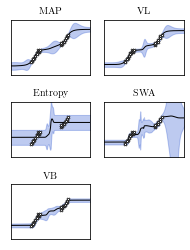

In [102]:
@torch.no_grad()
def plot_predictions(model, axs, prob=True):
    if prob:
        mean, var = model(X_test)
        # mean, var = model(X_test, pred_type="nn", n_samples=1000)
        std = torch.sqrt(torch.flatten(var) + model.sigma_noise.item()**2)
        mean = mean.flatten()
    else:
        mean = model(X_test).flatten()
        std = np.ones_like(mean)
    axs.plot(X_test, mean, c=c4, lw=1);
    # axs.plot(X_test, mean, c=c4, lw=2);
    
    if std is not None:
        axs.fill_between(X_test.flatten(), mean-1.96*std, mean+1.96*std, color=c1, alpha=0.3);

    axs.scatter(X.flatten(), y.flatten(), marker='X', s=10, c='white', edgecolors='black', lw=0.6, zorder=100);
    axs.set_xlim(-8, 8)
    axs.set_xticks([])
    axs.set_ylim(-100, 100)
    axs.set_yticks([])

dataloader = TensorDataset(X_train.unsqueeze(dim=0), y_train.unsqueeze(dim=0))
dataloader.dataset = X_train

# some plotting options
A4_width = 8.27
A4_height = 11.69
# just one column 
textwidth = 5.50107 * 0.5
fig, axs = plt.subplots(3, 2, figsize=(textwidth, 1.3 * textwidth))

for cur_model, name, cur_ax in zip([model, model_01, ent_model, swa_model], ["MAP", "VL", "Entropy", "SWA"],  axs.flat):
    model_la = fit_la(cur_model, dataloader)
    plot_predictions(model_la, cur_ax)
    cur_ax.set_title(name, fontsize=10)

# add vb
sample_preds = []
with torch.no_grad():
    for i in range(1000):
        sample_preds.append(bnn_model(X_test))
sample_preds = torch.stack(sample_preds).flatten(-2)
pred_mean = sample_preds.mean(dim=0)
pred_std = sample_preds.std(dim=0)

vb_axs = axs.flat[-2]
vb_axs.plot(X_test, pred_mean, c=c4, lw=1);

vb_axs.fill_between(X_test.flatten(), pred_mean-1.96*pred_std, pred_mean+1.96*pred_std, color=c1, alpha=0.3);

vb_axs.scatter(X.flatten(), y.flatten(), marker='X', s=10, c='white', edgecolors='black', lw=0.6, zorder=100);
vb_axs.set_xlim(-8, 8)
vb_axs.set_xticks([])
vb_axs.set_ylim(-100, 100)
vb_axs.set_yticks([])
vb_axs.set_title("VB", fontsize=10)

axs.flat[-1].axis("off")
fig.tight_layout()
# plt.subplots_adjust(hspace=0.25)
fig.savefig("Predictions_horiz.pdf")

# SGD

(2002, 61)
[[17.971561   4.812416 ]
 [17.869886   4.6864514]
 [17.680151   4.4479413]
 [17.417355   4.110634 ]]
[[17.97155878  4.81241584]
 [17.95522246  4.86172197]
 [17.70275268  4.66646222]
 [17.31473118  4.31692292]]


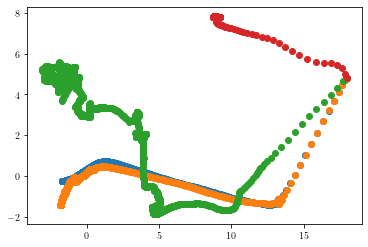

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


print(sgd_trajectories.shape)

# PCA projection of parameters 
pca = PCA(n_components=2).fit(sgd_trajectories)
sgd_traj_proj = pca.transform(sgd_trajectories)
sgd_01_traj_proj = pca.transform(sgd_01)
bnn_tarj_proj = pca.transform(bnn_trajectory)
swa_traj_proj = pca.transform(swa_traj)
ent_traj_proj = pca.transform(ent_traj)

print(sgd_traj_proj[:4])
print(bnn_tarj_proj[:4])

plt.scatter(sgd_traj_proj[:, 0], sgd_traj_proj[:, 1])
plt.scatter(sgd_01_traj_proj[:, 0], sgd_01_traj_proj[:, 1])
plt.scatter(bnn_tarj_proj[:, 0], bnn_tarj_proj[:, 1])
plt.scatter(ent_traj_proj[:, 0], ent_traj_proj[:, 1])
# plt.scatter(swa_traj_proj[:, 0], swa_traj_proj[:, 1])

In [44]:
from matplotlib import ticker
from matplotlib.colors import LogNorm

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

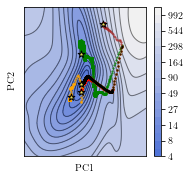

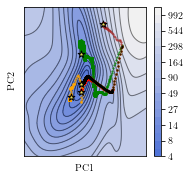

In [57]:
from backpack.utils.convert_parameters import vector_to_parameter_list
from matplotlib.colors import ListedColormap


def plot_loss_landscape(X_train, y_train, return_thetas=False):
    # In PCA space
    grid_size = 100
    # range_x = np.linspace(-50, 50, grid_size)
    # range_y = np.linspace(-30, 30, grid_size)
    range_y = np.linspace(-10, 10, grid_size)
    range_x = np.linspace(-30, 30, grid_size)
    w1s, w2s = np.meshgrid(range_x, range_y)
    thetas_latent = np.stack([w1s.ravel(), w2s.ravel()]).T
    
    # Project back to the parameter space
    thetas = pca.inverse_transform(thetas_latent)
    thetas = torch.from_numpy(thetas).float()
    
    losses = []
    ggns = []
    n_params = parameters_to_vector(nn.Sequential(nn.Linear(n,h), nn.Tanh(), nn.Linear(h, 1)).parameters()).shape[0]
    
    for theta in thetas:
        _model = nn.Sequential(nn.Linear(n,h), nn.Tanh(), nn.Linear(h, 1))
        _loss_fun = nn.MSELoss()
        extend(_model)
        extend(_loss_fun)
        # vector_to_parameter_list(theta, _model.parameters())
        for new_p, model_p in zip(vector_to_parameter_list(theta, _model.parameters()), _model.parameters()):
            model_p.data = new_p.data

        with backpack(DiagGGNExact()):
            loss = _loss_fun(_model(X_train), y_train) + 5e-4 * parameters_to_vector(_model.parameters()).square().sum()
            loss.backward()
            log_det_loss = 0
            for name, param in _model.named_parameters():
                log_det_loss += param.diag_ggn_exact.log().sum()
            ggns.append(log_det_loss.detach().clone()/n_params)


        # for p in _model.parameters():
        #     loss += weight_decay/2 * torch.norm(p, 2)
        
        losses.append(loss.item())
    
    ggns = np.array(ggns)
    # print(ggns.min(), ggns.max())
    # print(np.isnan(np.mean(ggns)))
    losses = np.array(losses)
    # losses = np.minimum(2700, losses)
    losses = np.log(losses)
    
    # Marquis de Laplace's colormap
    N = 25
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(c1[0], c3[0], N)
    vals[:, 1] = np.linspace(c1[1], c3[1], N)
    vals[:, 2] = np.linspace(c1[2], c3[2], N)
    cmap = ListedColormap(vals)
    
    # fig, (ax, ax2) = plt.subplots(1, 2, figsize=(25,10))
    # l = ax.contourf(
    #     w1s, w2s, losses.reshape(grid_size, grid_size), levels=20, 
    #     cmap=cmap, alpha=0.8, 
    # )
    # l2 = ax2.contourf(
    #     w1s, w2s, ggns.reshape(grid_size, grid_size), levels=20, 
    #     cmap=cmap, alpha=0.8, 
    # )
    # ax.contour(
    #     w1s, w2s, losses.reshape(grid_size, grid_size), levels=20, 
    #     alpha=0.5, colors='k'
    # )
    # fig.colorbar(l, ax=ax)
    # fig.colorbar(l2, ax=ax2)

    # return (fig, ax, w1s, w2s, thetas_latent) if return_thetas else (fig, ax, ax2)
    
    # plt.xticks([])
    # plt.yticks([])
    fig, ax = plt.subplots(1, figsize=(0.5 * textwidth, 0.5 * textwidth))
    l = ax.contourf(
        w1s, w2s, losses.reshape(grid_size, grid_size), levels=20, 
        cmap=cmap, alpha=0.8, 
    )
    ax.contour(
        w1s, w2s, losses.reshape(grid_size, grid_size), levels=20, 
        alpha=0.5, colors='k'
    )
    cbar = fig.colorbar(l, ax=ax)
    ticks = cbar.get_ticks()
    ticks = [[int(np.exp(x)), 0] for x in ticks]
    cbar.set_ticklabels(np.array(ticks).flatten(), fontsize=10)
    
    plt.xticks([])
    plt.yticks([])
    
    return (fig, ax, w1s, w2s, thetas_latent) if return_thetas else (fig, ax)

def plot_trajectory(traj, ax, col=c3, label=None):
    ax.scatter(traj[:, 0], traj[:, 1], c=col, edgecolors=c4, lw=0, alpha=0.8, zorder=9, label=label, s=5)
    ax.scatter(traj[-1:, 0], traj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=50, lw=1, zorder=10)
    
fig, ax = plot_loss_landscape(X_train, y_train)
plot_trajectory(sgd_01_traj_proj, ax, col="red", label="VL")
plot_trajectory(bnn_tarj_proj, ax, col="green", label="VB")
plot_trajectory(swa_traj_proj, ax, col="orange", label="SWA")
plot_trajectory(ent_traj_proj, ax, col="brown", label="ENT")
plot_trajectory(sgd_traj_proj, ax, col="black", label="MAP")
# ax.scatter(sgd_traj_proj[:, 0], sgd_traj_proj[:, 1], c=c3, edgecolors=c4, lw=0, alpha=1, zorder=9)
# ax.scatter(sgd_traj_proj[-1:, 0], sgd_traj_proj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=200, lw=1.5, zorder=10)
# ax.scatter(sgd_01_traj_proj[:, 0], sgd_01_traj_proj[:, 1], c="red", edgecolors=c4, lw=0, alpha=1, zorder=9)
# ax.scatter(sgd_01_traj_proj[-1:, 0], sgd_01_traj_proj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=200, lw=1.5, zorder=10)

# ax2.scatter(sgd_traj_proj[:, 0], sgd_traj_proj[:, 1], c=c3, edgecolors=c4, lw=0, alpha=1, zorder=9)
# ax2.scatter(sgd_traj_proj[-1:, 0], sgd_traj_proj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=200, lw=1.5, zorder=10)
# ax2.scatter(sgd_01_traj_proj[:, 0], sgd_01_traj_proj[:, 1], c="red", edgecolors=c4, lw=0, alpha=1, zorder=9)
# ax2.scatter(sgd_01_traj_proj[-1:, 0], sgd_01_traj_proj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=200, lw=1.5, zorder=10)

# plot_trajectory(sgd_traj_proj, ax2, col="black")
# plot_trajectory(sgd_01_traj_proj, ax2, col="red")
# plot_trajectory(bnn_tarj_proj, ax2, col="green")

# ax.set_title("Loss landscape (log of MSE)", fontsize=25)
# ax.legend()
ax.set_xlabel("PC1", fontsize=10)
ax.set_ylabel("PC2", fontsize=10)
# ax2.set_title("negative Entropy landscape", fontsize=25)
fig
# fig.savefig("Comparison_VI.jpg")

In [58]:
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.4, -0.2), ncol=2, handletextpad=0.2, labelspacing=0.2, columnspacing=1)

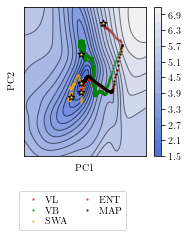

In [36]:
fig

In [59]:
fig.tight_layout()
fig.savefig("Final_Comparison.pdf",  bbox_extra_artists=(lgd,))

In [38]:
from src.metrics.distance import wasserstein_diag_gauss

In [39]:
parameters_to_vector(get_blitz_params(bnn_model, "rho")).shape

torch.Size([61])

In [40]:
vb_var

NameError: name 'vb_var' is not defined

In [ ]:
vb_mu, vb_var = parameters_to_vector(get_blitz_params(bnn_model, "mu")), parameters_to_vector(get_blitz_params(bnn_model, "rho"))
for cur_model, name in zip([model, model_01, ent_model, swa_model], ["MAP", "VL", "Entropy", "SWA"]):
    model_la = fit_la(cur_model, dataloader)
    var = model_la.H.to_matrix().diag()
    mean = parameters_to_vector(cur_model.parameters())
    print(name, wasserstein_diag_gauss(mean, var, vb_mu, vb_var))

100%|██████████| 100/100 [00:00<00:00, 1551.62it/s]


tensor([9.6433e-04, 1.0716e-03, 1.5948e+01, 7.0214e-04, 8.0016e-04, 1.0900e+03,
        7.3941e-04, 9.3354e-04, 7.1490e-02, 2.9773e-03, 3.2276e-02, 1.2112e-03,
        1.5395e-02, 2.8815e-03, 1.4100e-03, 8.4523e-04, 1.0877e-03, 4.6251e-03,
        5.6834e-03, 9.9282e-04, 8.3515e-03, 9.2804e-03, 1.3811e+02, 6.0808e-03,
        6.9298e-03, 9.4414e+03, 6.4036e-03, 8.0848e-03, 6.1913e-01, 2.5785e-02,
        2.7952e-01, 1.0489e-02, 1.3333e-01, 2.4955e-02, 1.2211e-02, 7.3201e-03,
        9.4199e-03, 4.0056e-02, 4.9220e-02, 8.5983e-03, 1.2557e-01, 6.2331e-02,
        4.3776e-02, 6.0203e-02, 5.8692e-02, 4.3597e-02, 6.1516e-02, 6.3330e-02,
        4.9085e-02, 6.9398e-02, 4.6929e-02, 6.9444e-02, 7.0926e-02, 6.6066e-02,
        6.2147e-02, 6.1832e-02, 6.9168e-02, 7.2121e-02, 7.6759e-02, 6.1093e-02,
        4.3478e-02])
MAP tensor(nan, grad_fn=<AddBackward0>)


100%|██████████| 100/100 [00:00<00:00, 1490.52it/s]


tensor([1.0864e+05, 1.0160e-03, 3.8273e+12, 6.7108e-04, 7.7297e-04, 2.7361e+13,
        7.1068e-04, 8.6839e-04, 1.2687e+10, 7.7999e-03, 4.7281e+05, 1.3583e-03,
        6.1550e+06, 3.9697e-03, 1.4052e-03, 7.6347e-04, 1.0989e-03, 8.6714e-03,
        3.8258e+01, 9.6106e-04, 9.4268e+05, 8.7990e-03, 3.2003e+13, 5.8119e-03,
        6.6943e-03, 2.3034e+14, 6.1548e-03, 7.5206e-03, 1.0969e+11, 6.7551e-02,
        4.0920e+06, 1.1763e-02, 3.7155e+06, 3.4379e-02, 1.2170e-02, 6.6120e-03,
        9.5168e-03, 7.5098e-02, 3.3497e+02, 8.3232e-03, 4.3480e-02, 6.1957e-02,
        4.3478e-02, 6.0198e-02, 5.8668e-02, 4.3478e-02, 6.2017e-02, 6.4389e-02,
        4.3478e-02, 6.1692e-02, 4.3479e-02, 6.5954e-02, 4.3478e-02, 6.5984e-02,
        6.1869e-02, 6.2695e-02, 6.9246e-02, 6.5416e-02, 4.4314e-02, 6.1100e-02,
        4.3478e-02])
VL tensor(nan, grad_fn=<AddBackward0>)


100%|██████████| 100/100 [00:00<00:00, 1490.65it/s]


tensor([       inf, 2.7748e+11,        inf, 1.0603e+06,        inf, 1.6612e+07,
        4.5506e+28, 1.4463e+31, 5.7320e+30, 3.2392e+07, 3.3978e+21, 3.3248e+21,
        4.3522e+07, 6.0024e+19, 3.2889e+22, 6.9837e+14, 1.6384e+14, 4.6279e+09,
               inf,        inf,        inf, 2.4031e+12,        inf, 9.1823e+06,
               inf, 1.4387e+08, 3.8722e+34, 1.8299e+29, 2.8417e+28, 2.8053e+08,
        1.0434e+23, 3.4236e+25, 3.7692e+08, 3.0012e+20, 1.3681e+24, 1.0381e+14,
        4.8868e+16, 4.0119e+10,        inf,        inf, 4.3478e-02, 4.3478e-02,
        4.3478e-02, 4.3478e-02, 4.3478e-02, 4.3478e-02, 4.3478e-02, 4.3478e-02,
        4.3478e-02, 4.3478e-02, 4.3478e-02, 4.3478e-02, 4.3478e-02, 4.3478e-02,
        4.3478e-02, 4.3478e-02, 4.3478e-02, 4.3479e-02, 4.3478e-02, 4.3478e-02,
        4.3478e-02])
Entropy tensor(nan, grad_fn=<AddBackward0>)


100%|██████████| 100/100 [00:00<00:00, 1547.29it/s]

tensor([4.5372e-04, 9.0017e-04, 3.2139e+07, 1.1080e+18, 2.7193e+07, 1.4198e+01,
        3.1752e+16, 8.0528e+11, 2.1422e+04, 4.8874e-01, 7.4109e+07, 2.9876e-03,
        2.1778e+12, 6.1613e-03, 1.2884e-03, 5.5173e+01, 1.1617e+05, 1.2190e+00,
        1.3887e+07, 2.6459e+05, 3.9294e-03, 7.7958e-03, 2.7835e+08, 1.1173e+20,
        2.3614e+08, 1.2297e+02, 5.7185e+15, 7.6634e+12, 1.8554e+05, 4.2327e+00,
        6.4272e+08, 2.5874e-02, 1.1174e+10, 5.3360e-02, 1.1158e-02, 4.7678e+02,
        2.1351e+06, 1.0555e+01, 1.1870e+05, 2.2915e+06, 4.7668e-02, 5.2345e-02,
        4.3479e-02, 4.3478e-02, 4.3479e-02, 4.3675e-02, 4.3478e-02, 4.3478e-02,
        4.3479e-02, 4.3966e-02, 4.3478e-02, 5.3870e-02, 4.3478e-02, 5.0743e-02,
        5.2540e-02, 4.3506e-02, 4.3478e-02, 4.4429e-02, 4.3478e-02, 4.3482e-02,
        4.3478e-02])
SWA tensor(nan, grad_fn=<AddBackward0>)
